In [7]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import scipy

import warnings
warnings.filterwarnings('ignore')

In [8]:
# 데이터셋 경로 설정
train_images_dir = r'D:\pythonProject\hansik\final_foods\Training'
valid_images_dir = r'D:\pythonProject\hansik\final_foods\Validation'
test_images_dir = r'D:\pythonProject\hansik\final_foods\Test'

# 하위 폴더 이름들을 추출하여 리스트로 만듦
food_list = [folder for folder in os.listdir(train_images_dir) if os.path.isdir(os.path.join(train_images_dir, folder))]

# 리스트 출력
print(food_list)
print("food_list의 길이는 ==== ",len(food_list))

# 데이터셋 생성기 파라미터 설정
image_size = (299, 299)
batch_size = 32

# 데이터 증강을 위한 ImageDataGenerator 생성
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


# 검증 데이터는 증강을 적용하지 않음
valid_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

# 데이터셋 생성
train_generator = train_datagen.flow_from_directory(
    train_images_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    valid_images_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    valid_images_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

['가지볶음', '간장게장', '갈비구이', '갈비찜', '갈비탕', '갈치구이', '갈치조림', '감자전', '감자조림', '감자채볶음', '감자탕', '갓김치', '건새우볶음', '경단', '계란국', '계란말이', '계란찜', '계란후라이', '고등어구이', '고등어조림', '고사리나물', '고추장진미채볶음', '고추튀김', '곰탕_설렁탕', '곱창구이', '곱창전골', '과메기', '김밥', '김치볶음밥', '김치전', '김치찌개', '김치찜', '깍두기', '깻잎장아찌', '꼬막찜', '꽁치조림', '꽈리고추무침', '꿀떡', '나박김치', '누룽지', '닭갈비', '닭계장', '닭볶음탕', '더덕구이', '도라지무침', '도토리묵', '동그랑땡', '동태찌개', '된장찌개', '두부김치', '두부조림', '땅콩조림', '떡갈비', '떡국_만두국', '떡꼬치', '떡볶이', '라면', '라볶이', '막국수', '만두', '매운탕', '멍게', '메추리알장조림', '멸치볶음', '무국', '무생채', '물냉면', '물회', '미역국', '미역줄기볶음', '배추김치', '백김치', '보쌈', '부추김치', '북엇국', '불고기', '비빔냉면', '비빔밥', '산낙지', '삼겹살', '삼계탕', '새우볶음밥', '새우튀김', '생선전', '소세지볶음', '송편', '수육', '수정과', '수제비', '숙주나물', '순대', '순두부찌개', '시금치나물', '시래기국', '식혜', '알밥', '애호박볶음', '약과', '약식', '양념게장', '양념치킨', '어묵볶음', '연근조림', '열무국수', '열무김치', '오이소박이', '오징어채볶음', '오징어튀김', '우엉조림', '유부초밥', '육개장', '육회', '잔치국수', '잡곡밥', '잡채', '장어구이', '장조림', '전복죽', '젓갈', '제육볶음', '조개구이', '조기구이', '족발', '주꾸미볶음', '주먹밥', '짜장면', '짬뽕', '쫄면', '찜닭', '총각김치', '추어탕', '칼국수

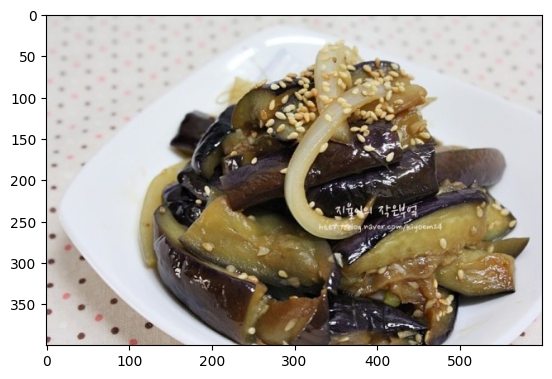

In [9]:
# 클래스의 이미지 랜덤하게 1개 보여주는 함수

import random
from matplotlib import pyplot as plt

def show_random_image_in_train_set(food_name):
    img_path = os.path.join(train_images_dir, food_name)
    imgs_list = os.listdir(img_path)
    img = random.choice(imgs_list)
    plt.imshow(plt.imread(os.path.join(img_path, img)))
show_random_image_in_train_set("가지볶음")

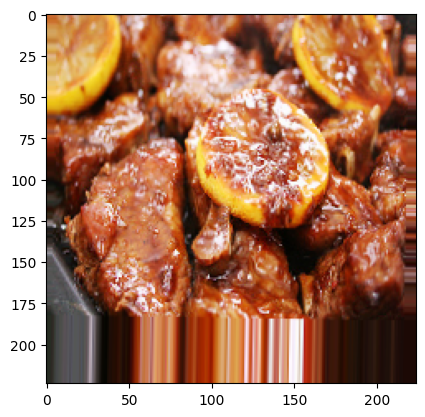

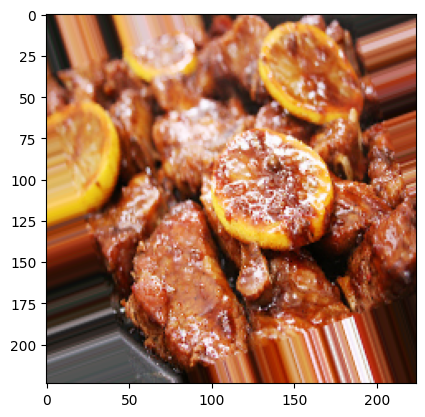

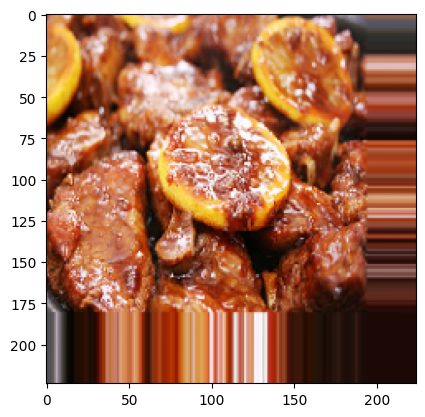

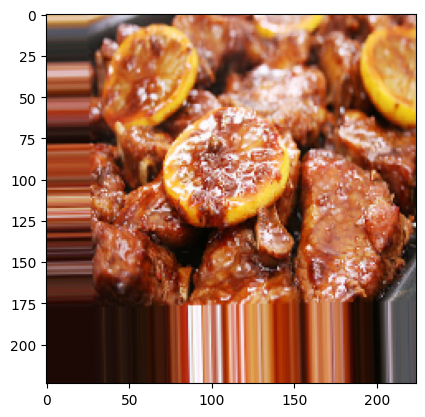

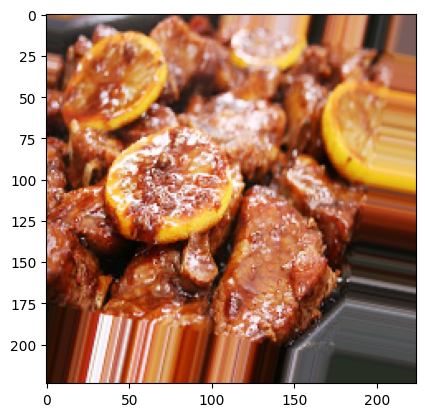

In [10]:
# 실행 시마다 parameter 범위 내에서 random하게 그림이 변형되므로 다른 변형된 그림들이 나타남
from tensorflow.keras.preprocessing import image
%matplotlib inline
sample_img_path = r'D:\pythonProject\hansik\final_foods\Training\갈비구이\Img_000_0007.jpg'

img = image.load_img(sample_img_path, target_size = (224, 224))

x = image.img_to_array(img)
x = x.reshape((1,) + x.shape)

i = 0
for batch in train_datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 5 == 0:
        break # break 하지 않으면 generator 는 무한히 반복됨

plt.show()

In [11]:
num_classes = 150

# InceptionV3 모델 불러오기
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(image_size[0], image_size[1], 3))

# 사전 학습된 모델의 일부 레이어만 학습 가능하도록 설정
for layer in base_model.layers[:-10]:
    layer.trainable = False

# 커스터마이징을 위한 새로운 레이어 추가
inputs = Input(shape=(image_size[0], image_size[1], 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs, outputs)

# 모델 구조 요약 출력
model.summary()


# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 batch_normalization_190 (B  (None, 2048)              8192      
 atchNormalization)                                              
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               5245

In [12]:
# 체크포인트 콜백 설정
checkpoint_path = "training/cp.weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = ModelCheckpoint(filepath=checkpoint_path,
                              save_weights_only=True,
                              monitor='val_loss',
                              mode='min',
                              save_best_only=True,
                              verbose=1)

# 조기 종료 콜백
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

# 학습률 감소 콜백
reduce_lr_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)

# 이전에 저장된 체크포인트가 있는지 확인
if os.path.exists(checkpoint_path):
    model.load_weights(checkpoint_path)

# 모델 훈련
history = model.fit(train_generator,
                    validation_data=valid_generator,
                    epochs=30,
                    callbacks=[cp_callback, early_stopping_callback, reduce_lr_callback],
                    verbose=1)

Epoch 1/30
1851/1851 [==============================] - ETA: 0s - loss: 2.4959 - accuracy: 0.3729
Epoch 1: val_loss improved from inf to 1.85517, saving model to training\cp.weights.h5
1851/1851 [==============================] - 4501s 2s/step - loss: 2.4959 - accuracy: 0.3729 - val_loss: 1.8552 - val_accuracy: 0.4985 - lr: 0.0100
Epoch 2/30
1851/1851 [==============================] - ETA: 0s - loss: 2.0893 - accuracy: 0.4511
Epoch 2: val_loss improved from 1.85517 to 1.74369, saving model to training\cp.weights.h5
1851/1851 [==============================] - 4651s 3s/step - loss: 2.0893 - accuracy: 0.4511 - val_loss: 1.7437 - val_accuracy: 0.5248 - lr: 0.0100
Epoch 3/30
1851/1851 [==============================] - ETA: 0s - loss: 1.9968 - accuracy: 0.4727
Epoch 3: val_loss improved from 1.74369 to 1.68269, saving model to training\cp.weights.h5
1851/1851 [==============================] - 4625s 2s/step - loss: 1.9968 - accuracy: 0.4727 - val_loss: 1.6827 - val_accuracy: 0.5400 - lr: 

In [ ]:
# 훈련 이력 시각화
def plot_history(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

plot_history(history)

NameError: name 'history' is not defined

In [ ]:
# h5 확장자 형태로 모델을 저장
model.save('InceptionV3 model.h5')

# 모델 불러오기
model = load_model('InceptionV3 model.h5')

# validation set에서 모델 평가 (기준 : accuracy, confusion_matrix 시각화)
import numpy as np
from sklearn.metrics import confusion_matrix

# 검증 셋으로 predict를 할 때, shuffle=False로 지정해야 섞이지 않은 상태에서 
# 실젯값과 예측값을 비교할 수 있다.

valid_generator2 = valid_datagen.flow_from_directory(
    valid_images_dir,
    target_size=image_size,
    batch_size=batch_size,
    shuffle=False
)
valid_prediction = model.predict_generator(valid_generator2, steps = len(valid_generator2))


In [ ]:
# 각 index별 음식 이름
food_classes = valid_generator2.class_indices
print(food_classes)

In [ ]:
# y가 예측한 레이블
val_y_pred = np.argmax(valid_prediction, axis = 1)
# 실제 y 값
val_y_true = valid_generator2.classes

print("val_y_pred ===  ", val_y_pred[:50])
print("val_y_true ===  ", val_y_true[:50])

In [ ]:
# confusion_matrix
food_confusion_matrix = confusion_matrix(val_y_true, val_y_pred)
print(food_confusion_matrix)
print("shape==", food_confusion_matrix.shape)

In [ ]:
# confusion matrix 시각화
import seaborn as sns
import pandas as pd

# 단순히 갯수로 비교하면 이미지가 많은 클래스가 상대적으로 나쁘게 보일 수 있다.
# 현재 validation set의 class별 이미지 갯수는 전처리 과정에서 일부 누락된 게 있어 모두 100개가 아님
# --> 비율로 confusion_matrix를 normalize한다!

row_sums = food_confusion_matrix.sum(axis=1, keepdims=True)
norm_conf_mx = food_confusion_matrix / row_sums

df_cm = pd.DataFrame(norm_conf_mx, index = range(150),columns=range(150))

plt.figure(figsize = (20,14))
plt.title("confusion_matrix (x : Predicted, y : Actual) ")

sns.heatmap(df_cm, annot=False, cmap="Blues")

In [ ]:
# confusion_matrix에서 상대적으로 잘 분류된 음식과 그렇지 않은 음식 확인하기

# food_dict -> key : 음식 이름, value : index인 dictionary
food_dict = valid_generator2.class_indices
# foods_prob : (음식 이름, 음식의 index, 예측값=실제값일 확률)인 tuple을 각 원소로 갖는 list
foods_prob = [(food_name,idx, prob) for food_name, idx, prob in zip(food_dict.keys(), food_dict.values() ,np.diag(norm_conf_mx))]
foods_prob =  sorted(foods_prob,key= lambda x : x[2])
print(foods_prob)

In [ ]:
# 잘 분류될 확률이 60% 이하인 음식들
bad_classfifed_foods = [food_prob for food_prob in foods_prob if food_prob[2] <= 0.6 ]
bad_classfifed_foods

In [ ]:
# test set에서의 loss, accuracy 확인
test_loss, test_acc = model.evaluate_generator(test_generator,steps= len(test_generator), use_multiprocessing=True, verbose=2)
# loss, acc 출력
print("loss, acc ===", test_loss, test_acc)